In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
csv_X_path = r".\Datos\X.csv"
csv_Y_path = r".\Datos\Y.csv"
csv_Z_path = r".\Datos\Z.csv"

In [3]:
csv_X = pd.read_csv(csv_X_path).dropna(how="any")  # año-mes-día
csv_Y = pd.read_csv(csv_Y_path, sep = ";", decimal=',').dropna(how="any") # El archivo tiene una delimitación (separador) diferente y \
                                                        # recordar que la estructura es día/mes/año, tiene comas en vez de puntos para decimales
csv_Z = pd.read_csv(csv_Z_path).dropna(how="any")    # año-mes-día

## Vamos a ver rápidamente cuál es la estructura general

In [5]:
csv_X.head(2)

,Date,Price
0,2024-04-04,89.18
1,2024-04-03,89.35


In [6]:
csv_Y.head(2)

,Date,Price
0,12/9/2023,547.33
1,11/9/2023,546.00


In [7]:
csv_Z.head(2)

,Price,Date
0,2225.25,2010-01-01
1,2225.25,2010-01-04


## Vamos a dejar todas las tablas con el mismo formato de fecha y orden de columnas

In [9]:
csv_Z = csv_Z[['Date', 'Price']]            # cambia el orden de la columna para mantener consistencia de nomenclatura y estética

In [10]:
csv_Y['Date'] = (
    pd.to_datetime(csv_Y['Date'],           # "31/8/2023"
                   format='%d/%m/%Y',       # DD/MM/YYYY
                   errors='coerce')         
      .dt.strftime('%Y-%m-%d')              # Resultado final
    
)

## Vamos a normalizar la cola de cada tabla, para que todos terminen en un mismo mes. Ya que hay tablas más recientes que otras

In [12]:
for df in (csv_X, csv_Y, csv_Z):
    df.sort_values("Date", inplace=True)

In [13]:
csv_X.tail(2)

,Date,Price
1,2024-04-03,89.35
0,2024-04-04,89.18


In [14]:
csv_Y.tail(2)

,Date,Price
1,2023-09-11,546.00
0,2023-09-12,547.33


In [15]:
csv_Z.tail(2)

,Date,Price
3563,2023-08-30,2140.25
3564,2023-08-31,2165.25


In [16]:
CUT = "2023-08-31"

csv_X, csv_Y, csv_Z = [
    df.assign(Date=pd.to_datetime(df["Date"]))     # ensure real datetimes
      .set_index("Date")                           # make it the index
      .sort_index()                                # must be monotonic for .loc slices
      .loc[:CUT]                                   # keep ≤ CUT
    for df in (csv_X, csv_Y, csv_Z)
]

In [17]:
# LOWER, UPPER = "2000-01-01", "2023-08-31"
# csv_X, csv_Y, csv_Z = [
#     (df.assign(Date=pd.to_datetime(df["Date"]))
#        .set_index("Date")
#        .sort_index()
#        .loc[LOWER:UPPER])
#     for df in (csv_X, csv_Y, csv_Z)
# ]


In [18]:
(csv_X.tail(2), csv_Y.tail(2), csv_Z.tail(2))

(            Price
 Date             
 2023-08-30  85.86
 2023-08-31  86.86,
              Price
 Date              
 2023-08-30  543.67
 2023-08-31  545.00,
               Price
 Date               
 2023-08-30  2140.25
 2023-08-31  2165.25)

### vamos hacer un poco de exploración para entender los datos

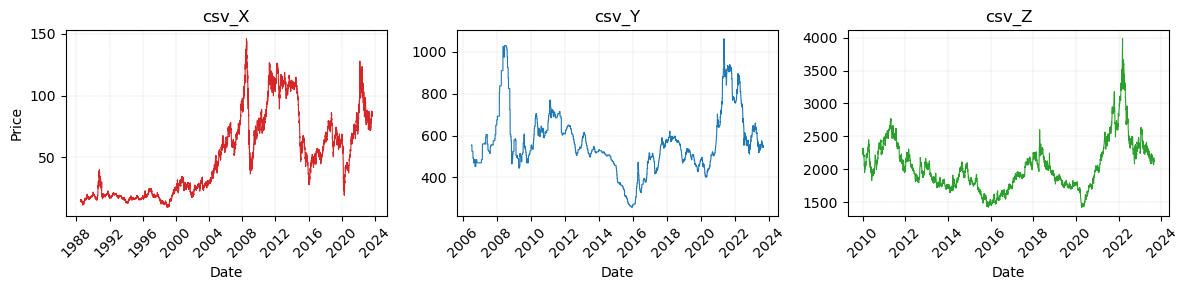

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

specs = [("csv_X", csv_X, "tab:red"),
         ("csv_Y", csv_Y, "tab:blue"),
         ("csv_Z", csv_Z, "tab:green")]

for ax, (name, df, color) in zip(axes, specs):
    ax.plot(df.index, df["Price"], lw=.8, color=color)  # Date está en el índice
    ax.set_title(name)
    ax.set_xlabel("Date")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(ls="--", lw=.3, alpha=.6)

axes[0].set_ylabel("Price")  # solo la primera comparte etiqueta y

fig.tight_layout()
plt.show()

### eda for X

In [22]:
csv_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8990 entries, 1988-06-27 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   8990 non-null   float64
dtypes: float64(1)
memory usage: 140.5 KB


In [23]:
csv_X.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,8990.0,50.766185,32.990241,9.64,19.59,44.83,73.8575,146.08


In [24]:
csv_Y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4477 entries, 2006-07-11 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   4477 non-null   float64
dtypes: float64(1)
memory usage: 70.0 KB


In [25]:
csv_Y.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,4477.0,565.486113,145.278631,257.5,485.0,543.13,619.25,1062.37


In [26]:
csv_Z.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3565 entries, 2010-01-01 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3565 non-null   float64
dtypes: float64(1)
memory usage: 55.7 KB


In [27]:
csv_Z.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,3565.0,2037.081197,372.976076,1421.5,1767.5,1974.75,2235.75,3984.0


In [28]:
def decompose(df, value_col="Price", period=None, n=None, model="additive"):
    s = df[value_col].tail(n) if n else df[value_col]      # expects a DateTimeIndex
    res = seasonal_decompose(s, model=model, period=period)

    comps  = [res.observed, res.trend, res.seasonal, res.resid]
    titles = ["Observed", "Trend", "Seasonal", "Residual"]

    fig, axes = plt.subplots(4, 1, figsize=(14, 7), sharex=True)
    for ax, title, series in zip(axes, titles, comps):
        ax.plot(series.index, series.values)
        ax.set_title(title)
        ax.grid(alpha=.3)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

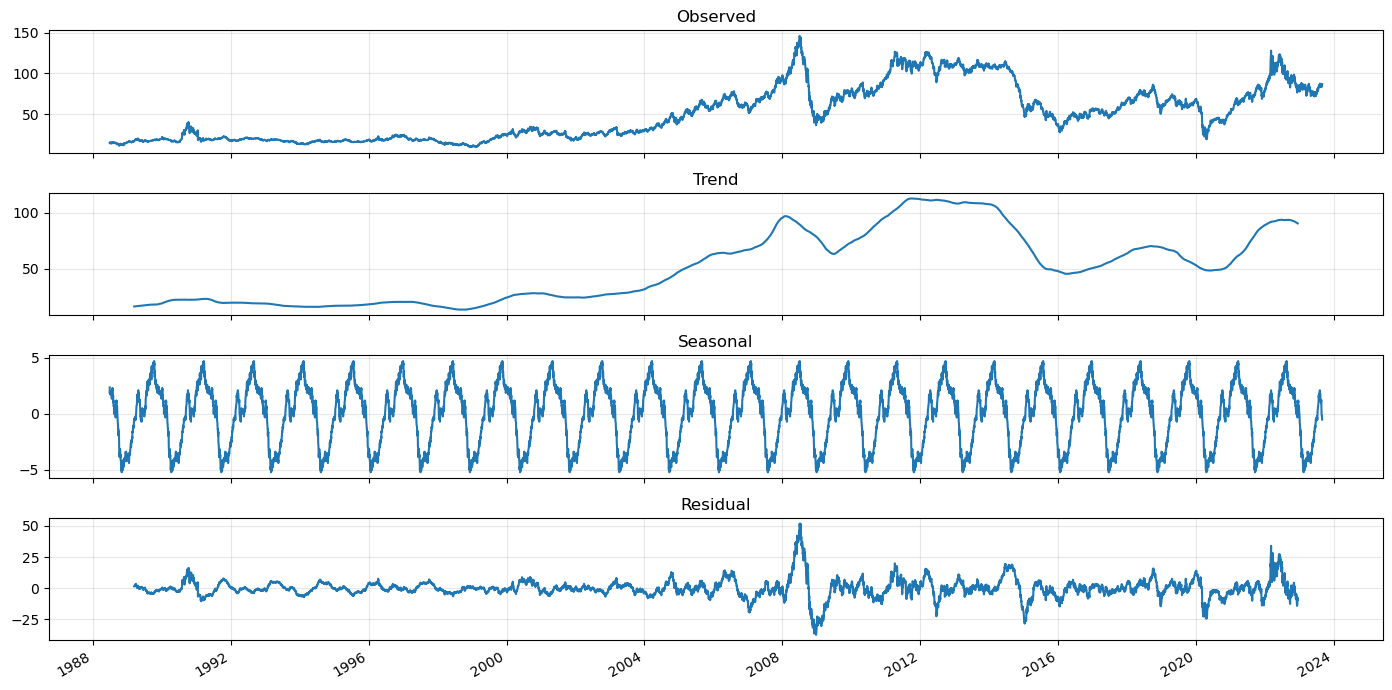

In [29]:
csv_X.index = pd.to_datetime(csv_X.index)  # ensure dtype
decompose(csv_X, period=365)

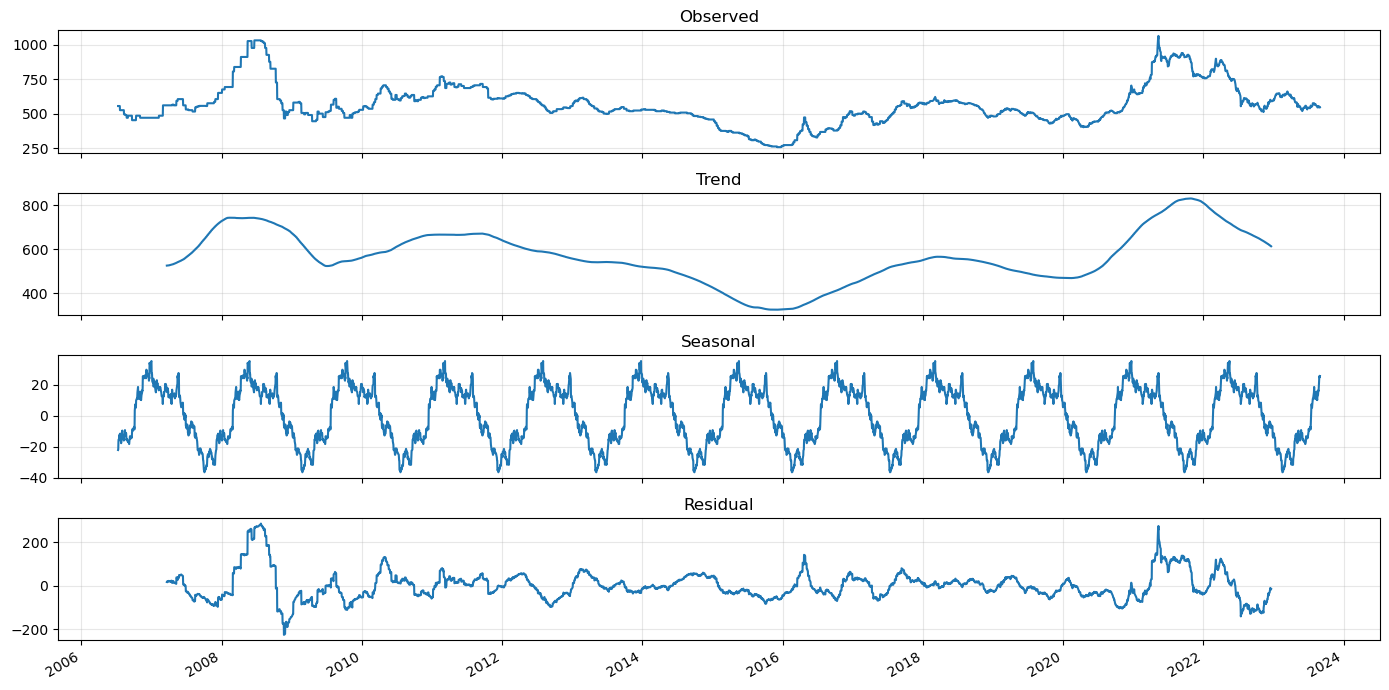

In [30]:
csv_Y.index = pd.to_datetime(csv_Y.index)  # ensure dtype
decompose(csv_Y, period=365)

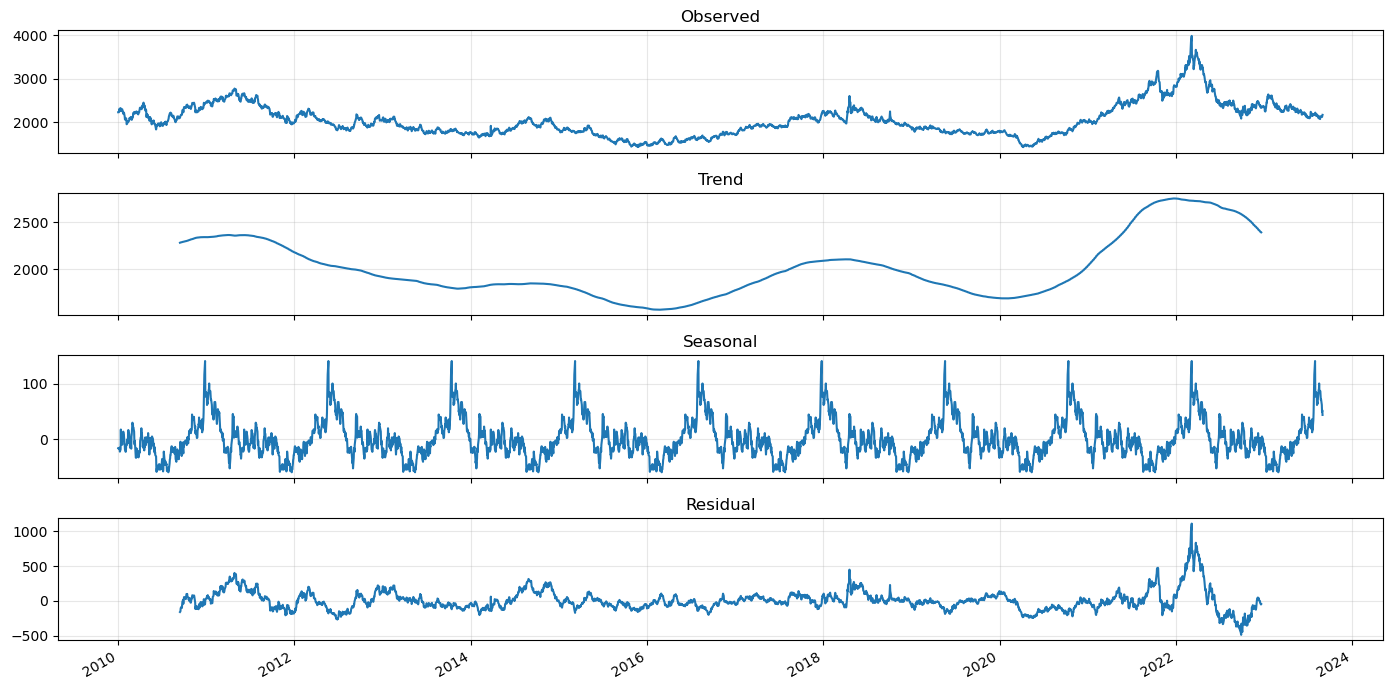

In [31]:
csv_Z.index = pd.to_datetime(csv_Z.index)  # ensure dtype
decompose(csv_Z, period=365)

In [32]:
# !pip install lightgbm

In [33]:
# def prepare_data(df):
#     df       = df.copy()
#     df.index = pd.to_datetime(df.index)
#     df       = df.sort_index()
#     df["date_num"] = df.index.view("int64") // 10**9
#     df["lag_1"]    = df["Price"].shift(1)
#     df["diff_1"]   = df["Price"].diff()
#     df       = df.dropna()
#     return df.select_dtypes("number")      # keep only numeric cols (incl. Price)

def prepare_data(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Time features (safe)
    df["month"]      = df.index.month
    df["date_num"]   = df.index.view("int64") // 10**9

    # Safe lags
    df["lag_1"]      = df["Price"].shift(1)
    df["lag_2"]      = df["Price"].shift(2)
    df["lag_3"]      = df["Price"].shift(3)
    df["lag_4"]      = df["Price"].shift(4)
    df["lag_12"]      = df["Price"].shift(12)

    return df.dropna().copy()

def train_time_series_with_folds(df, horizon=6):
    X = df.drop("Price", axis=1)
    y = df["Price"]

    X_train, X_test = X.iloc[:-horizon], X.iloc[-horizon:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

    model = LGBMRegressor(random_state=42, verbose=-1).fit(X_train, y_train)
    preds = model.predict(X_test)
    mae   = round(mean_absolute_error(y_test, preds), 3)

    return model, y_train, y_test, preds, mae

In [34]:
def plot_forecast(y_train, y_test, preds):

    plt.figure(figsize=(12, 5))

    # training history
    plt.plot(y_train.index, y_train, color="grey", lw=0.8, label="Train")

    # real test values (dots + connecting line)
    plt.scatter(y_test.index, y_test, color="red", s=10)              # dots
    plt.plot   (y_test.index, y_test, color="red", lw=1.2, label="Real")  # line

    # model predictions (dots + connecting line)
    plt.scatter(y_test.index, preds, color="green", s=10)             # dots
    plt.plot   (y_test.index, preds, color="green", lw=1.2, label="Pred") # line

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

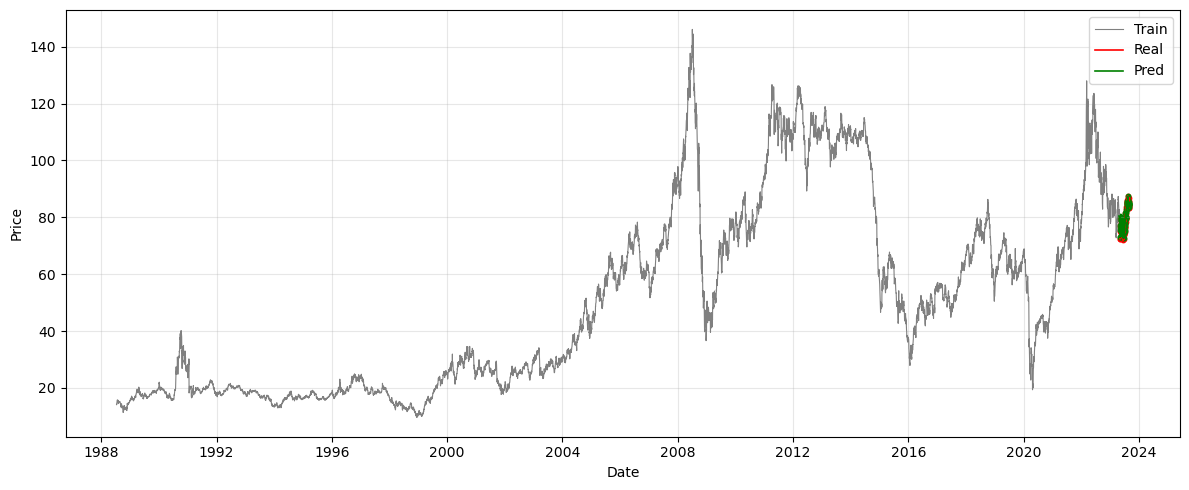

In [35]:
df_ready = prepare_data(csv_X)

model, y_train, y_test, prd, mae = train_time_series_with_folds(df_ready, horizon = 90)

plot_forecast(y_train, y_test, prd)

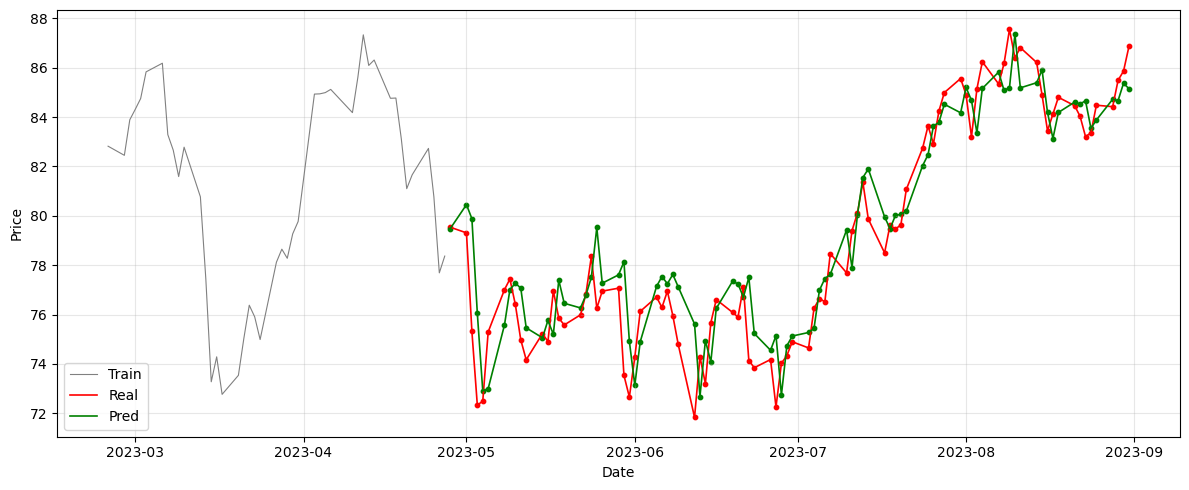

In [36]:
train_trail = y_train.iloc[-int(len(y_train) * 0.005):]
plot_forecast(train_trail, y_test, prd)

# day to day prediction is difficult, we may create a code that let us aggregate by (month, ...)

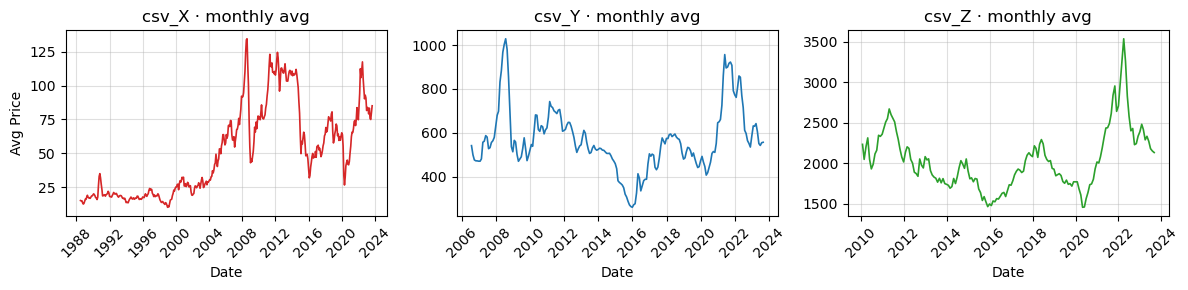

In [38]:
def agg_monthly(df, value_col="Price"):
    return (
        df[value_col]
          .resample("ME")             # month-end
          .mean()
          .to_frame()                # returns DataFrame with 'Price'
    )

X_m, Y_m, Z_m = map(agg_monthly, (csv_X, csv_Y, csv_Z))

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=False)

for ax, (name, df_m, color) in zip(
        axes,
        [("csv_X", X_m, "tab:red"),
         ("csv_Y", Y_m, "tab:blue"),
         ("csv_Z", Z_m, "tab:green")]):

    ax.plot(df_m.index, df_m["Price"], lw=1.2, color=color)
    ax.set_title(f"{name} · monthly avg")
    ax.set_xlabel("Date")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(alpha=.4)

axes[0].set_ylabel("Avg Price")
fig.tight_layout()
plt.show()

In [39]:
X_m.head(2)

,Price
Date,
1988-06-30,15.172500
1988-07-31,14.924286


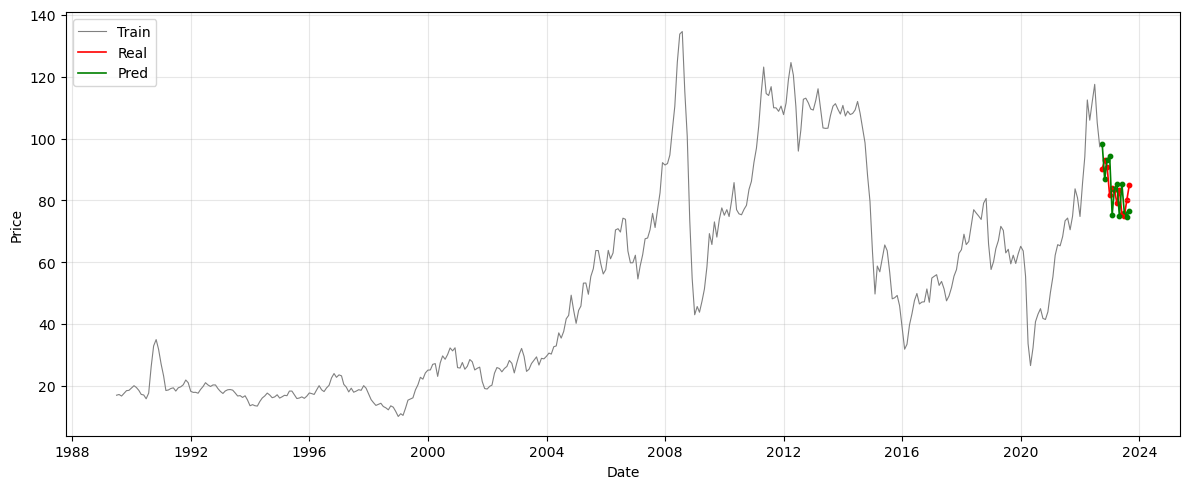

In [40]:
df_ready = prepare_data(X_m)

n_months = 12

model, y_train, y_test, prd, mae = train_time_series_with_folds(df_ready, horizon = n_months)

plot_forecast(y_train, y_test, prd)

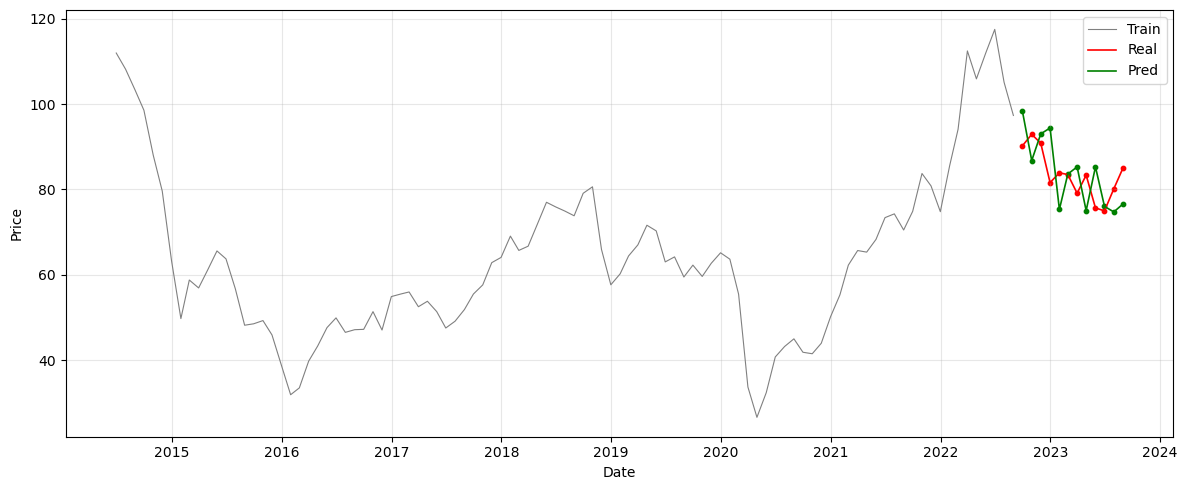

In [41]:
train_trail = y_train.iloc[-int(len(y_train) * 0.25):]
plot_forecast(train_trail, y_test, prd)

### ok, let's model all three for the 6 months

In [43]:
df_ready_X = prepare_data(X_m)
df_ready_Y = prepare_data(Y_m)
df_ready_Z = prepare_data(Z_m)

model_X, y_train_X, y_test_X, prd_X, mae_X = train_time_series_with_folds(df_ready_X, horizon = n_months)
model_Y, y_train_Y, y_test_Y, prd_Y, mae_Y = train_time_series_with_folds(df_ready_Y, horizon = n_months)
model_Z, y_train_Z, y_test_Z, prd_Z, mae_Z = train_time_series_with_folds(df_ready_Z, horizon = n_months)

In [44]:
df_ready_X.tail(2)

,Price,month,date_num,lag_1,lag_2,lag_3,lag_4,lag_12
Date,,,,,,,,
2023-07-31,80.160000,7,1690761600,74.978636,75.694783,83.368947,79.125652,105.123810
2023-08-31,85.104348,8,1693440000,80.160000,74.978636,75.694783,83.368947,97.345652


In [45]:
df_ready_Y.tail(2)

,Price,month,date_num,lag_1,lag_2,lag_3,lag_4,lag_12
Date,,,,,,,,
2023-07-31,554.357619,7,1690761600,541.775909,550.593913,604.575000,641.466957,611.174762
2023-08-31,556.303913,8,1693440000,554.357619,541.775909,550.593913,604.575000,596.376957


In [46]:
df_ready_Z.tail(2)

,Price,month,date_num,lag_1,lag_2,lag_3,lag_4,lag_12
Date,,,,,,,,
2023-07-31,2152.011905,7,1690761600,2180.738636,2271.586957,2333.300000,2289.684783,2401.071429
2023-08-31,2133.021739,8,1693440000,2152.011905,2180.738636,2271.586957,2333.300000,2429.836957


### Para el equipo 1 tenemos una distribución 20% de X y 80% de Y (puede entenderse como 2 unidades por cada 8, o literalmente 0.2 vs 0.8, usaremos el segundo por simplicidad)

In [48]:
trail_n = 0.25

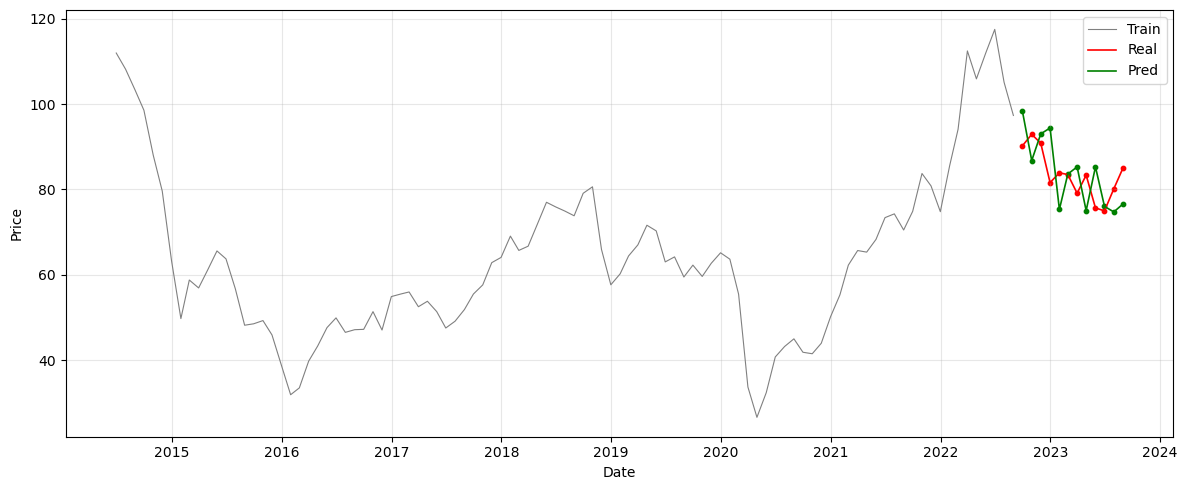

In [49]:
train_trail_X = y_train_X.iloc[-int(len(y_train_X) * trail_n):]
plot_forecast(train_trail_X, y_test_X, prd_X)

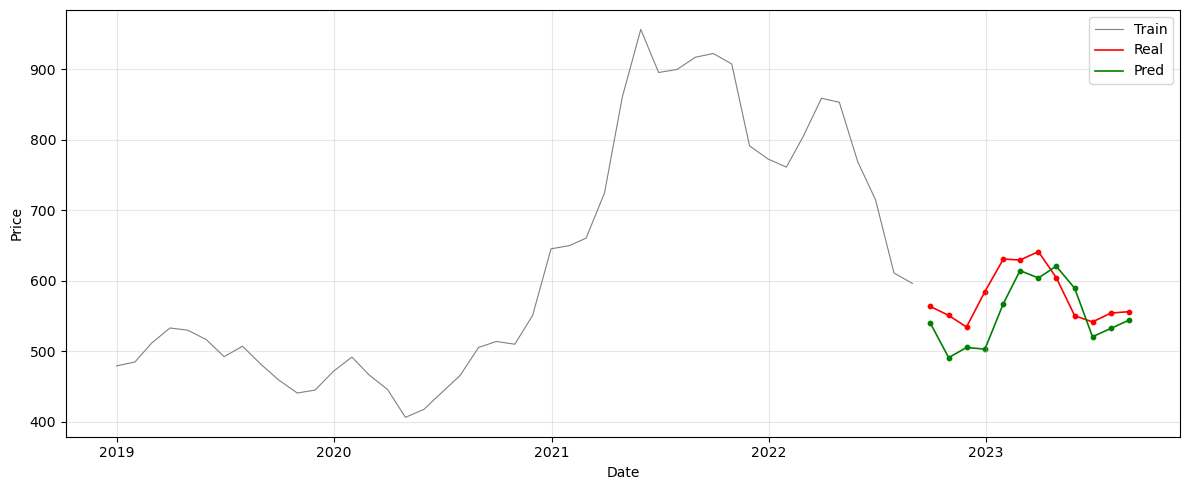

In [50]:
train_trail_Y = y_train_Y.iloc[-int(len(y_train_Y) * trail_n):]
plot_forecast(train_trail_Y, y_test_Y, prd_Y)

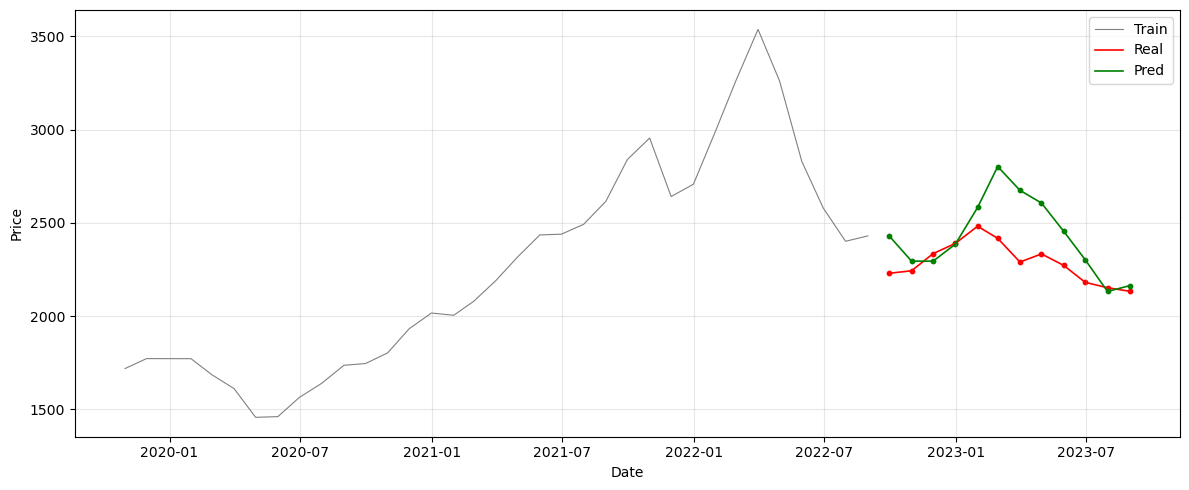

In [51]:
train_trail_Z = y_train_Z.iloc[-int(len(y_train_Z) * trail_n):]
plot_forecast(train_trail_Z, y_test_Z, prd_Z)

In [52]:
y_test_X.tail(1)

Date
2023-08-31    85.104348
Freq: ME, Name: Price, dtype: float64

In [53]:
y_test_Y.tail(1)

Date
2023-08-31    556.303913
Freq: ME, Name: Price, dtype: float64

In [54]:
y_test_Z.tail(1)

Date
2023-08-31    2133.021739
Freq: ME, Name: Price, dtype: float64

In [55]:
a, b, c = 1/3, 1/3, 1/3

trail_X = train_trail_X.rename("Train_Trail_X")
trail_Y = train_trail_Y.rename("Train_Trail_Y")
trail_Z = train_trail_Z.rename("Train_Trail_Z")

pred_X = pd.Series(prd_X, index=y_test_X.index, name="Predicted_X")
pred_Y = pd.Series(prd_Y, index=y_test_Y.index, name="Predicted_Y")
pred_Z = pd.Series(prd_Z, index=y_test_Z.index, name="Predicted_Z")

df = pd.concat(
    {
        "Price_Real_X":    y_test_X,
        "Price_Real_Y":    y_test_Y,
        "Price_Real_Z":    y_test_Z,
        "Predicted_X":     pred_X,
        "Predicted_Y":     pred_Y,
        "Predicted_Z":     pred_Z,
        "Train_Trail_X":   trail_X,
        "Train_Trail_Y":   trail_Y,
        "Train_Trail_Z":   trail_Z,
    },
    axis=1,
    join="outer",
).sort_index()

df["real_equipo"]      = a * df["Price_Real_X"]   + b * df["Price_Real_Y"]   + c * df["Price_Real_Z"]
df["predicted_equipo"] = a * df["Predicted_X"]    + b * df["Predicted_Y"]    + c * df["Predicted_Z"]
df["train_equipo"]     = a * df["Train_Trail_X"]  + b * df["Train_Trail_Y"]  + c * df["Train_Trail_Z"]

In [56]:
df.head(2)

,Price_Real_X,Price_Real_Y,Price_Real_Z,Predicted_X,Predicted_Y,Predicted_Z,Train_Trail_X,Train_Trail_Y,Train_Trail_Z,real_equipo,predicted_equipo,train_equipo
Date,,,,,,,,,,,,
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,111.967143,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,108.185217,NaN,NaN,NaN,NaN,NaN


In [57]:
df.tail(2)

,Price_Real_X,Price_Real_Y,Price_Real_Z,Predicted_X,Predicted_Y,Predicted_Z,Train_Trail_X,Train_Trail_Y,Train_Trail_Z,real_equipo,predicted_equipo,train_equipo
Date,,,,,,,,,,,,
2023-07-31,80.160000,554.357619,2152.011905,74.746065,532.652254,2132.052475,NaN,NaN,NaN,928.843175,913.150264,NaN
2023-08-31,85.104348,556.303913,2133.021739,76.633742,544.485722,2163.152377,NaN,NaN,NaN,924.810000,928.090614,NaN


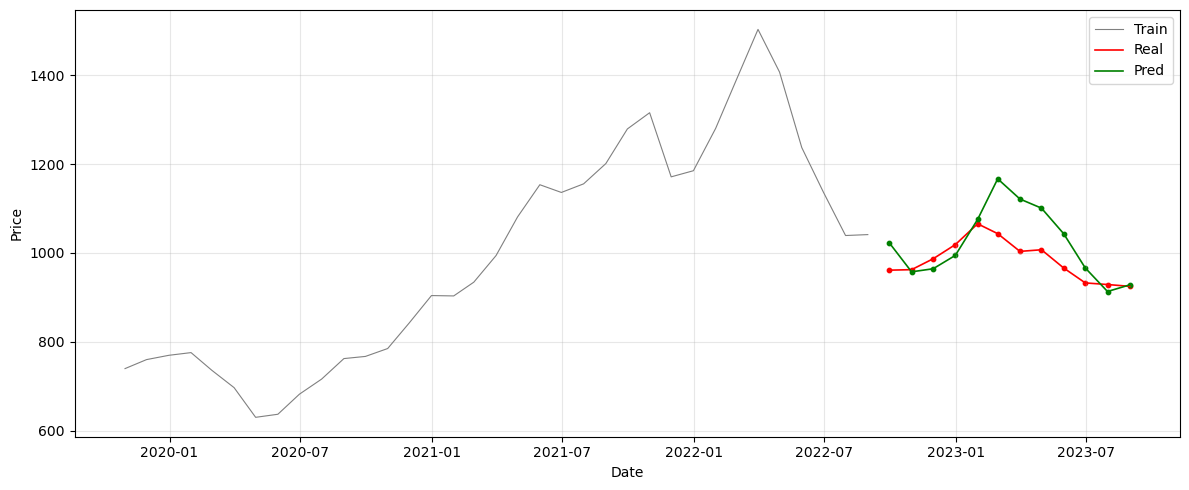

In [58]:
plot_forecast(df["train_equipo"], df["real_equipo"] , df["predicted_equipo"])